#### TODO:
##### 1. Adding a PI algo + visualization at each iteration
##### 2. Adding a VI algo + visualization at each iteration
##### 3. Adding a MCTS algo + visualization at each iteration

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment. 

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy. 


## The agent-environment interface

<img src="img/agent-environment.png" style="width: 500px;" align="left"/> 

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 


## The environment: Navigation in a gridworld

<img src="img/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](img/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [2]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

## Utility Function

In [3]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


In [48]:
def print_q_table(q_table):
    
    for coord, value in q_table.items():
        x,y = coord
        print(f"({x},{y}): {value}")
        

In [59]:
def show_policy_at_each_state(q_table):
    for coord, value in q_table.items():
        x,y = coord
        max_val = 0
        max_state = 'UP'
        for move, q_value in value.items():
            if q_value > max_val:
                max_val = q_value
                max_state = move
        
        print(f"Optimal Policy at ({x},{y}) is {max_state} and U(s) = {max_val}")

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [4]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, is_policy_iteration = False):
        # Set information about the gridworld
        self.height = 5
        self.width = 5
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))
        
        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]
        
        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
        self.is_policy_iteration = is_policy_iteration
        
        if self.is_policy_iteration:
            self.action_space = {'UP':-self.height, 'DOWN':self.width, 'LEFT':-1, 'RIGHT':-1}
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [5]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)   

In [6]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

        

In [49]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True 
        
        if type(agent) == Q_Agent:
            print(f"Trial {trial}:")
            print_q_table(agent.q_table)
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [38]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

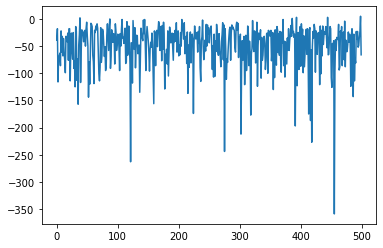

In [39]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

Trial 0:
(0,0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(2,0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(2,1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(2,2): {'UP': 0, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': -0.1}
(2,3): {'UP': -1.0, 'DOWN': 0, 'LEFT': -0.1, 'RIGHT': 0}
(2,4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(3,0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(3,1): {'UP': 0, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': -0.1}
(3,2): {'UP': -0.1, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': -0.1}
(3,3): {'UP': -0.1, 'DOWN': -0.110000000000

(0,2): {'UP': 0, 'DOWN': 0.6861970356236213, 'LEFT': 0, 'RIGHT': 9.975349652950424}
(0,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,4): {'UP': 0, 'DOWN': 0, 'LEFT': 6.5132155990000005, 'RIGHT': 0}
(1,0): {'UP': -0.4539000000000001, 'DOWN': -0.4709593900000001, 'LEFT': -0.4000000000000001, 'RIGHT': -0.29318619267325047}
(1,1): {'UP': -0.271, 'DOWN': -0.32871000000000006, 'LEFT': -0.21900000000000003, 'RIGHT': 1.8959643090373342}
(1,2): {'UP': 8.827673748200933, 'DOWN': 0.41243611514867545, 'LEFT': -0.1, 'RIGHT': -1.0}
(1,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,4): {'UP': 1.9876891491000004, 'DOWN': -0.11000000000000001, 'LEFT': -1.0, 'RIGHT': -0.2}
(2,0): {'UP': -0.8137109377778331, 'DOWN': -0.8059788334790903, 'LEFT': -0.8000000000000003, 'RIGHT': -0.7843426783620792}
(2,1): {'UP': -0.5774209110263999, 'DOWN': -0.5786077570000001, 'LEFT': -0.6006561000000001, 'RIGHT': 0.573562526024615}
(2,2): {'UP': 7.332517409404193, 'DOWN': -0.44070639, 'LEFT': -0.5171824271227552, 

Trial 160:
(0,0): {'UP': -0.2, 'DOWN': -0.31856806101, 'LEFT': -0.30000000000000004, 'RIGHT': -0.21583}
(0,1): {'UP': 0, 'DOWN': -0.11100000000000002, 'LEFT': -0.1, 'RIGHT': 2.341470861982834}
(0,2): {'UP': 0.8995432240925494, 'DOWN': 3.199345249685854, 'LEFT': 0.040338547369296526, 'RIGHT': 9.999997681730786}
(0,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,4): {'UP': 0, 'DOWN': 0, 'LEFT': 6.5132155990000005, 'RIGHT': 0}
(1,0): {'UP': -0.4539000000000001, 'DOWN': -0.4709593900000001, 'LEFT': -0.4000000000000001, 'RIGHT': -0.29318619267325047}
(1,1): {'UP': -0.271, 'DOWN': -0.32871000000000006, 'LEFT': -0.21900000000000003, 'RIGHT': 3.541878656710857}
(1,2): {'UP': 8.999969691484027, 'DOWN': 1.654965628786171, 'LEFT': 0.3393430945892921, 'RIGHT': -3.439}
(1,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,4): {'UP': 1.9876891491000004, 'DOWN': -0.11000000000000001, 'LEFT': -1.0, 'RIGHT': -0.2}
(2,0): {'UP': -0.8137109377778331, 'DOWN': -0.8059788334790903, 'LEFT': -0.80000000000

(3,1): {'UP': -0.9544015310467003, 'DOWN': -0.5403527380492514, 'LEFT': -1.0531792958875776, 'RIGHT': 5.99759332374295}
(3,2): {'UP': 6.9999996337228145, 'DOWN': 0.19353226123703693, 'LEFT': 0.7970359845486901, 'RIGHT': 1.2579933088910469}
(3,3): {'UP': -0.942576115512, 'DOWN': -1.028509286320091, 'LEFT': 5.997272637808158, 'RIGHT': -1.0736708857509}
(3,4): {'UP': -1.0993929518496712, 'DOWN': -1.2912580572777184, 'LEFT': -0.7544446308222197, 'RIGHT': -1.1000000000000005}
(4,0): {'UP': -1.8298986391165766, 'DOWN': -1.1637351011809038, 'LEFT': -1.8000000000000012, 'RIGHT': 3.3048029228590963}
(4,1): {'UP': 4.976843176414096, 'DOWN': -1.5000000000000009, 'LEFT': -1.4216330012419562, 'RIGHT': 0.16717841802604083}
(4,2): {'UP': 5.914906098911506, 'DOWN': -1.2963528297900007, 'LEFT': -1.0220283649356388, 'RIGHT': -0.8826295212845772}
(4,3): {'UP': 4.968626408991054, 'DOWN': -1.5000000000000009, 'LEFT': -1.4681064714977567, 'RIGHT': -0.9959902969200974}
(4,4): {'UP': -1.7077815041507791, 'DOW

(2,3): {'UP': -1.0, 'DOWN': -0.69348601793965, 'LEFT': 0.3894597607745363, 'RIGHT': -0.6610976700000001}
(2,4): {'UP': -0.279563270419, 'DOWN': -0.5417027100000001, 'LEFT': -0.6140237781896757, 'RIGHT': -0.6000000000000001}
(3,0): {'UP': -1.2472424330862177, 'DOWN': -1.3118923795465378, 'LEFT': -1.3000000000000007, 'RIGHT': 0.5822175871107461}
(3,1): {'UP': -0.7795028134740631, 'DOWN': -0.08806407990991971, 'LEFT': -1.0387237084687078, 'RIGHT': 5.999860031675817}
(3,2): {'UP': 6.999999999735108, 'DOWN': 1.4855416740086627, 'LEFT': 1.2173031222778485, 'RIGHT': 1.2579933088910469}
(3,3): {'UP': -0.942576115512, 'DOWN': -1.028509286320091, 'LEFT': 5.9999241358146485, 'RIGHT': -1.0736708857509}
(3,4): {'UP': -1.0993929518496712, 'DOWN': -1.2912580572777184, 'LEFT': -0.7544446308222197, 'RIGHT': -1.1000000000000005}
(4,0): {'UP': -1.8298986391165766, 'DOWN': -1.1637351011809038, 'LEFT': -1.8000000000000012, 'RIGHT': 3.663598029228739}
(4,1): {'UP': 4.9983604285508925, 'DOWN': -0.95082645830

(4,4): {'UP': -1.7077815041507791, 'DOWN': -1.2478429561426099, 'LEFT': 3.991565390455502, 'RIGHT': -0.5020332576771476}
Trial 410:
(0,0): {'UP': -0.2, 'DOWN': -0.31856806101, 'LEFT': -0.30000000000000004, 'RIGHT': -0.21583}
(0,1): {'UP': 0, 'DOWN': -0.11100000000000002, 'LEFT': -0.1, 'RIGHT': 3.6065913929535}
(0,2): {'UP': 4.216761268976395, 'DOWN': 4.111469652245535, 'LEFT': 0.35413897794574156, 'RIGHT': 9.999999999999995}
(0,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(0,4): {'UP': 0, 'DOWN': 0, 'LEFT': 6.5132155990000005, 'RIGHT': 0}
(1,0): {'UP': -0.4539000000000001, 'DOWN': -0.4709593900000001, 'LEFT': -0.4000000000000001, 'RIGHT': -0.29318619267325047}
(1,1): {'UP': -0.271, 'DOWN': -0.32871000000000006, 'LEFT': -0.21900000000000003, 'RIGHT': 3.987690791039204}
(1,2): {'UP': 8.999999999999982, 'DOWN': 3.1034636529057193, 'LEFT': 0.5595966508014486, 'RIGHT': -4.0951}
(1,3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
(1,4): {'UP': 1.9876891491000004, 'DOWN': -0.110000000000000

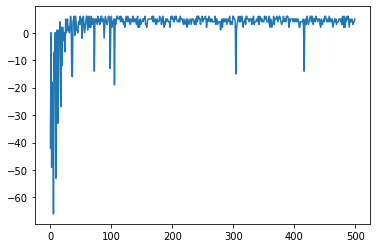

In [50]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [55]:
# pretty(agentQ.q_table)

Print the final Q-value table with nice formatting.

In [60]:
show_policy_at_each_state(agentQ.q_table)

Optimal Policy at (0,0) is UP and U(s) = 0
Optimal Policy at (0,1) is RIGHT and U(s) = 4.145932253658149
Optimal Policy at (0,2) is RIGHT and U(s) = 9.999999999999995
Optimal Policy at (0,3) is UP and U(s) = 0
Optimal Policy at (0,4) is LEFT and U(s) = 6.5132155990000005
Optimal Policy at (1,0) is UP and U(s) = 0
Optimal Policy at (1,1) is RIGHT and U(s) = 4.388921711935282
Optimal Policy at (1,2) is UP and U(s) = 8.999999999999982
Optimal Policy at (1,3) is UP and U(s) = 0
Optimal Policy at (1,4) is UP and U(s) = 1.9876891491000004
Optimal Policy at (2,0) is UP and U(s) = 0
Optimal Policy at (2,1) is RIGHT and U(s) = 4.9833158250093685
Optimal Policy at (2,2) is UP and U(s) = 7.999999999999978
Optimal Policy at (2,3) is LEFT and U(s) = 3.838199096253133
Optimal Policy at (2,4) is UP and U(s) = 0
Optimal Policy at (3,0) is RIGHT and U(s) = 1.0239866450709316
Optimal Policy at (3,1) is RIGHT and U(s) = 5.999999796264788
Optimal Policy at (3,2) is UP and U(s) = 6.9999999999999725
Optimal

### TESTING CODEE

In [34]:
list = np.empty(shape = (2,2), dtype = dict)
list[0,0] = {
    'Up': 0,
    'Down': 0,
    'Left' : 0,
    'Right': 0,
}

list[0,1] = {
    'Up': 0,
    'Down': 0,
    'Left' : -9,
    'Right': 1,
}

list[1,0] = {
    'Up': 2,
    'Down': 1,
    'Left' : 3,
    'Right': -1
}

list[1,1] = {
    'Up': 2,
    'Down': 1,
    'Left' : 3,
    'Right': -1
}

(0,0): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(0,1): {'Up': 0, 'Down': 0, 'Left': -9, 'Right': 1}
(1,0): {'Up': 2, 'Down': 1, 'Left': 3, 'Right': -1}
(1,1): {'Up': 2, 'Down': 1, 'Left': 3, 'Right': -1}
